<a href="https://colab.research.google.com/github/kit-wang/MITES-Thermodynamics/blob/main/MITES_thermo_rankine_cycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install coolprop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44.2 MB 194 kB/s 


Latent heat of water at 5 bar is 2.11 MJ/kg.


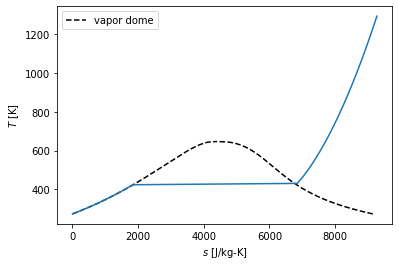

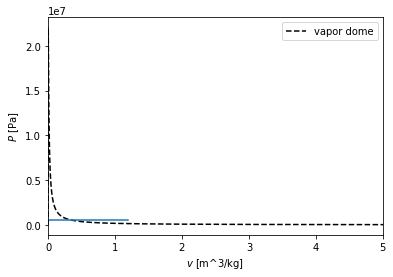

In [ ]:
from CoolProp.constants import PT_INPUTS
import CoolProp as cp
import numpy as np
from matplotlib import pyplot as plt

Water = cp.AbstractState('HEOS', 'Water')

T_c = Water.T_critical() # K
T_low = 273.15 # K

T_sweep = np.linspace(T_low, T_c, 150)
s_dome_left = []
s_dome_right = []
P_dome_left = []
P_dome_right = []
v_dome_left = []
v_dome_right = []

P_isobar = 5e5 # Pa
T_isobar_sweep = np.linspace(T_low, T_c*2, 150)

for T in T_sweep:
  Water.update(cp.QT_INPUTS, 0, T)
  s_dome_left.append(Water.smass())
  P_dome_left.append(Water.p())
  v_dome_left.append(1/Water.rhomass())
  Water.update(cp.QT_INPUTS, 1, T)
  s_dome_right.append(Water.smass())
  P_dome_right.append(Water.p())
  v_dome_right.append(1/Water.rhomass())

s_isobar = []
v_isobar = []

for T in T_isobar_sweep:
  Water.update(cp.PT_INPUTS, P_isobar, T)
  s_isobar.append(Water.smass())
  v_isobar.append(1/Water.rhomass())

Water.update(cp.PQ_INPUTS, 5e5, 1)
h_v = Water.hmass()
Water.update(cp.PQ_INPUTS, 5e5, 0)
h_l = Water.hmass()
latent_heat = h_v - h_l
print(f'Latent heat of water at 5 bar is {latent_heat/1e6:.3g} MJ/kg.')

plt.plot(s_dome_left, T_sweep, '--', color='black')
plt.plot(s_dome_right, T_sweep, '--', color='black', label='vapor dome')
plt.plot(s_isobar, T_isobar_sweep)
plt.xlabel('$s$ [J/kg-K]')
plt.ylabel('$T$ [K]')
plt.legend()
plt.show()

plt.plot(v_dome_left, P_dome_left, '--', color='black')
plt.plot(v_dome_right, P_dome_right, '--', color='black', label='vapor dome')
plt.plot(v_isobar, [P_isobar for v in v_isobar])
plt.xlabel('$v$ [m^3/kg]')
plt.ylabel('$P$ [Pa]')
plt.xlim([0, 5])
plt.legend()
plt.show()

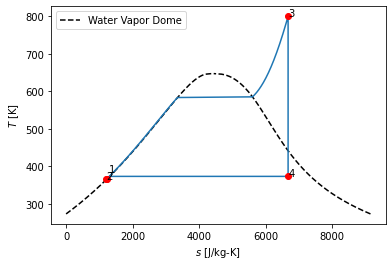

Rankine first law efficiency = 0.331
Carnot efficiency = 0.544
Second law efficiency = 0.61


In [ ]:
import CoolProp as cp
import numpy as np
from matplotlib import pyplot as plt

Water = cp.AbstractState('HEOS', 'Water')

T_dome = np.linspace(273.06, Water.T_critical()*0.99999, 250)
s_l_dome = []
h_l_dome = []
s_v_dome = []
h_v_dome = []
for T in T_dome:
  Water.update(cp.QT_INPUTS, 0, T)
  s_l_dome.append(Water.smass())
  h_l_dome.append(Water.hmass())
  Water.update(cp.QT_INPUTS, 1, T)
  s_v_dome.append(Water.smass())
  h_v_dome.append(Water.hmass())

# Given:
P_1 = 101325 # Pa
P_2 = P_1 * 100 # Pa
P_4 = P_1 # Isobaric condensation
T_1 = 365 # K
T_2 = T_1 # K (Isothermal pumping)
T_boiler = 800 # K
T_3 = T_boiler # K

# Simulate rankine cycle
s_cycle = []
u_cycle = []
T_cycle = []
P_cycle = []
h_cycle = []
# 1->2: Isothermal compression
Water.update(cp.PT_INPUTS, P_1, T_1)
h_1 = Water.hmass()
u_1 = Water.umass()
s_1 = Water.smass()
for P in np.linspace(P_1, P_2, 250):
  Water.update(cp.PT_INPUTS, P, T_1)
  s_cycle.append(Water.smass())
  u_cycle.append(Water.umass())
  T_cycle.append(Water.T())
  P_cycle.append(Water.p())
  h_cycle.append(Water.hmass())
h_2 = h_cycle[-1]
u_2 = u_cycle[-1]
s_2 = s_cycle[-1]
# 2->3: Isobaric evaporation
for T in np.linspace(T_2, T_3, 250):
  Water.update(cp.PT_INPUTS, P_2, T)
  s_cycle.append(Water.smass())
  u_cycle.append(Water.umass())
  T_cycle.append(Water.T())
  P_cycle.append(Water.p())
  h_cycle.append(Water.hmass())
h_3 = h_cycle[-1]
u_3 = u_cycle[-1]
s_3 = s_cycle[-1]
P_3 = P_cycle[-1]
# 3->4: Isentropic expansion through turbine
for P in np.linspace(P_3, P_4, 250):
  Water.update(cp.PSmass_INPUTS, P, s_3)
  s_cycle.append(Water.smass())
  u_cycle.append(Water.umass())
  T_cycle.append(Water.T())
  P_cycle.append(Water.p())
  h_cycle.append(Water.hmass())
h_4 = h_cycle[-1]
u_4 = u_cycle[-1]
s_4 = s_cycle[-1]
T_4 = T_cycle[-1]
# 4->1: Isobaric condensation
for s in np.linspace(s_4, s_1, 250):
  Water.update(cp.PSmass_INPUTS, P_4, s)
  s_cycle.append(Water.smass())
  u_cycle.append(Water.umass())
  T_cycle.append(Water.T())
  P_cycle.append(Water.p())
  h_cycle.append(Water.hmass())
# END SIMULATION

# Plot vapor dome
plt.plot(s_l_dome, T_dome, '--', color='black')
plt.plot(s_v_dome, T_dome, '--', color='black', label='Water Vapor Dome')
# Plot cycle
plt.plot(s_cycle, T_cycle, '-', color='tab:blue')
plt.plot(s_1, T_1, 'o', color='red')
plt.annotate('1', (s_1*1.05, T_1*1.05))
plt.plot(s_2, T_2, 'o', color='red')
plt.annotate('2', (s_2, T_2))
plt.plot(s_3, T_3, 'o', color='red')
plt.annotate('3', (s_3, T_3))
plt.plot(s_4, T_4, 'o', color='red')
plt.annotate('4', (s_4, T_4))
#plt.plot(s_4, T_4, 'o', color='red')
plt.legend()
plt.xlabel('$s$ [J/kg-K]')
plt.ylabel('$T$ [K]')
plt.savefig('name_of_fig.png', dpi=400)
plt.show()

w_dot_net = (h_3 - h_4) + (h_1 - h_2) # W/kg
q_dot_in = (h_3 - h_2) # W/kg
eta_rankine = w_dot_net / q_dot_in
eta_carnot = 1 - T_1 / T_boiler

print(f'Rankine first law efficiency = {eta_rankine:0.3g}')
print(f'Carnot efficiency = {eta_carnot:0.3g}')
print(f'Second law efficiency = {eta_rankine / eta_carnot:0.3g}') # <- how high can you get this changing P_2, T_boiler, T_1?